/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in multiply
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.7/site-packages/ipy

[0.04939949]
[0.04314134]
[0.01549465]
[0.04648197]
[0.01382631]
[0.14139364]
[0.02517785]
[0.1557332]
[0.07710282]
[0.04382334]
[0.01476936]
[0.03259258]
[0.11324567]
[0.01433803]
[-0.03545763]
[0.00233204]
[-0.01534839]
[0.14585902]
[0.10287558]
[0.05512189]
[0.11838288]
[0.13181935]
[0.12808212]
[0.10893918]


/Users/yjzhu/Desktop/Solar/MyPy/juanfit.py:547: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8*figsize_scale,8*figsize_scale))


[0.11657135]
[0.1214105]
[0.09961579]
[0.10847852]
[0.10387759]
[0.09908564]
[0.10241858]
[0.10056907]
[0.10098129]
[0.09904288]
[0.10018459]
[0.1019988]
[0.09981085]
[0.09721459]
[0.09690281]
[0.0945156]
[0.09489138]
[0.09428061]
[0.09364022]
[0.0972947]
[0.10008546]
[0.10152403]
[0.09735644]
[0.0968927]
[0.10103257]
[0.09913716]
[0.09753956]
[0.09560226]
[0.10733283]
[0.10053626]
[0.10170752]
[0.09717546]
[0.10347058]
[0.11526464]
[0.09225554]
[0.1133689]
[0.09312421]
[0.114885]
[0.13499966]
[0.13250457]
[0.12867187]
[0.12708399]
[0.15173509]


/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


[0.1]
[0.17703401]
[0.04033174]


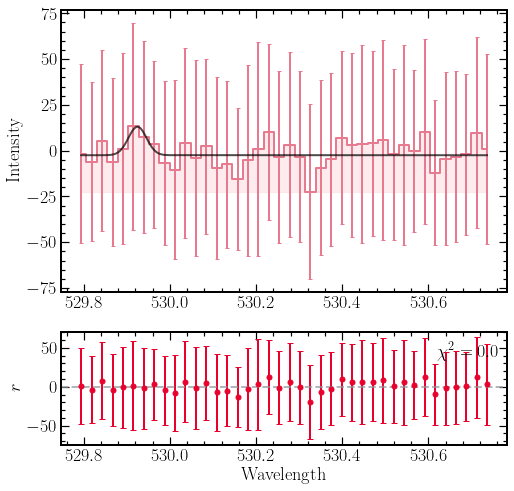

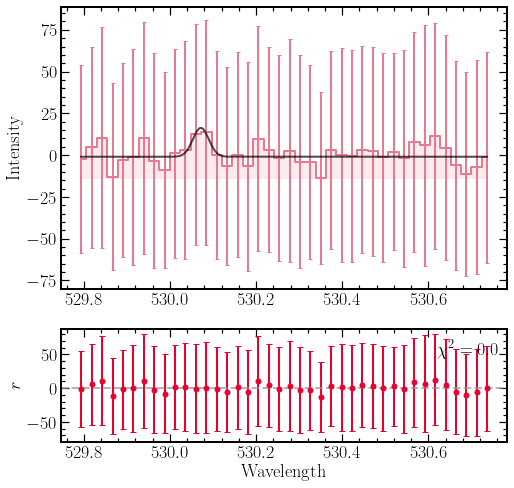

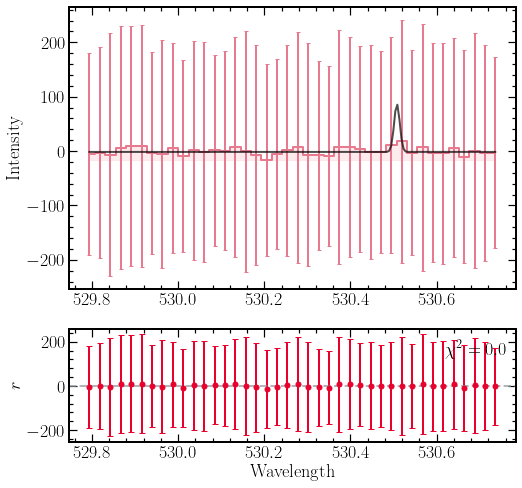

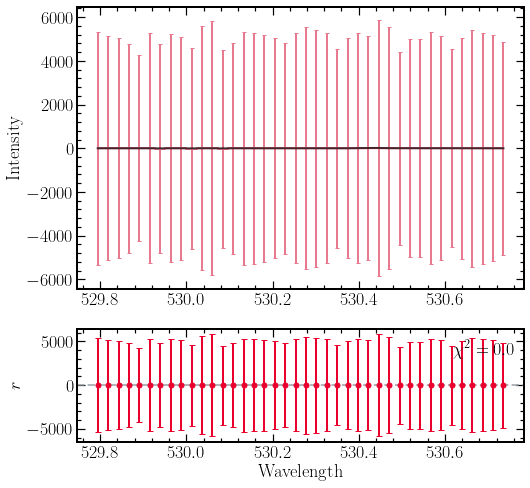

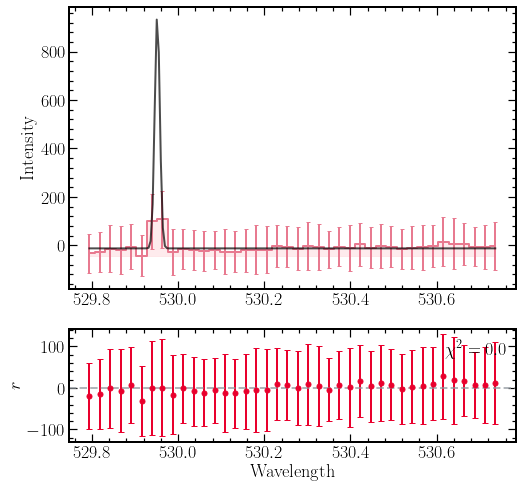

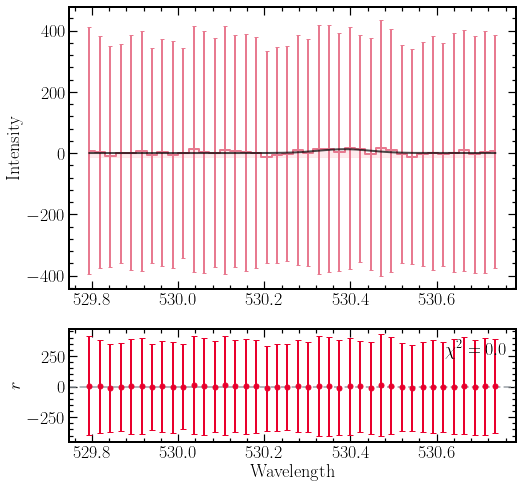

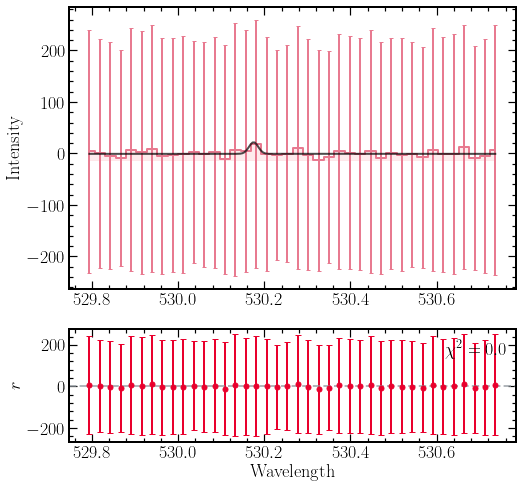

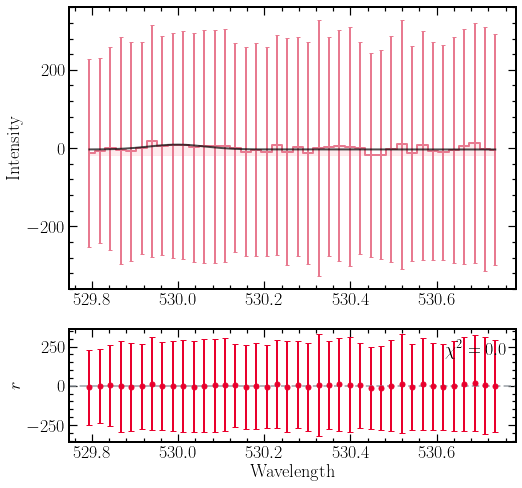

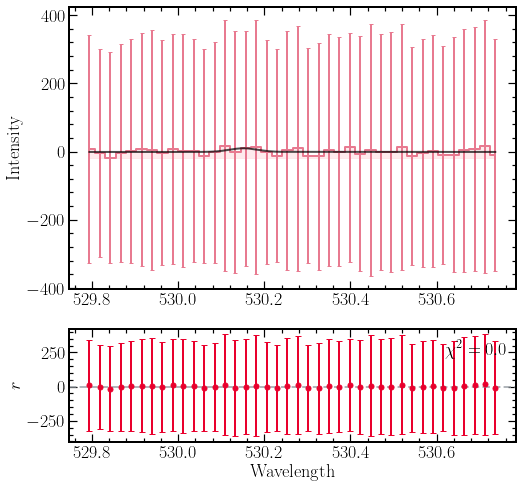

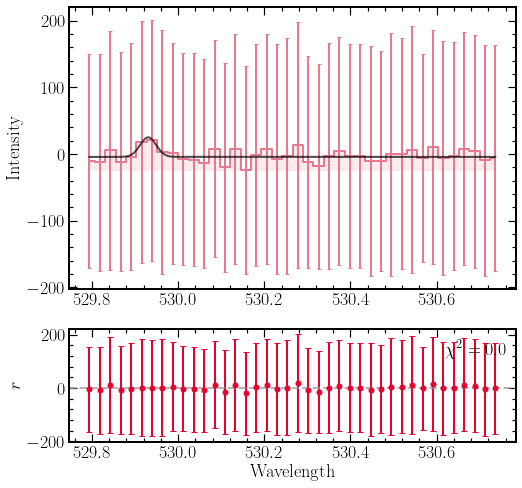

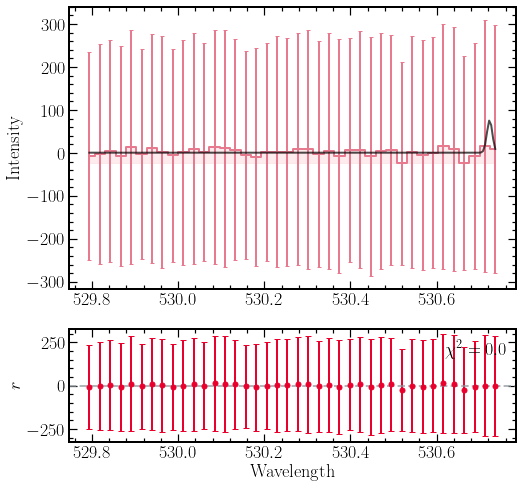

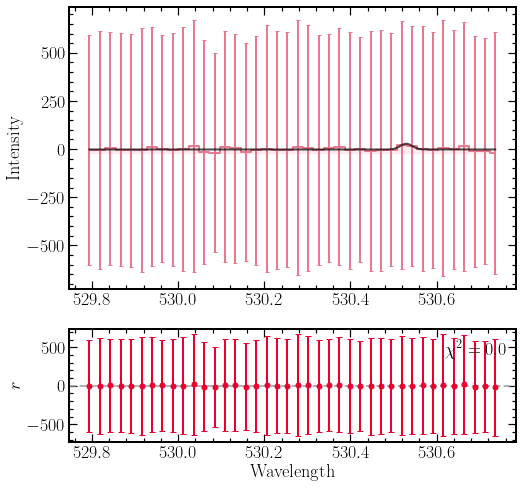

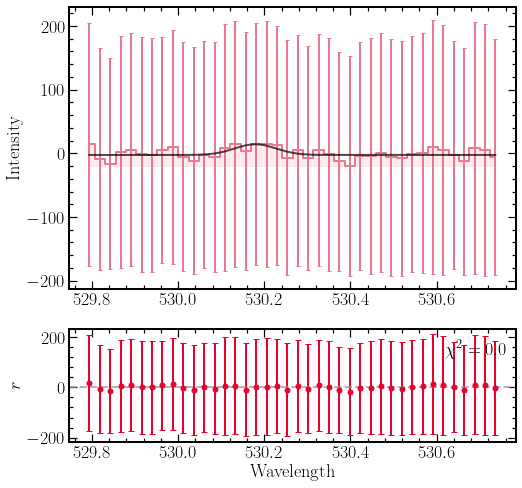

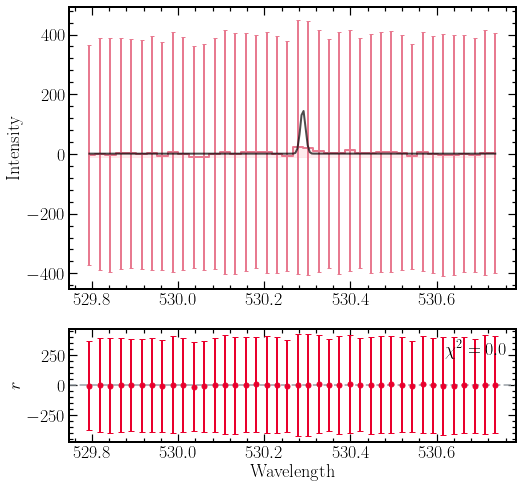

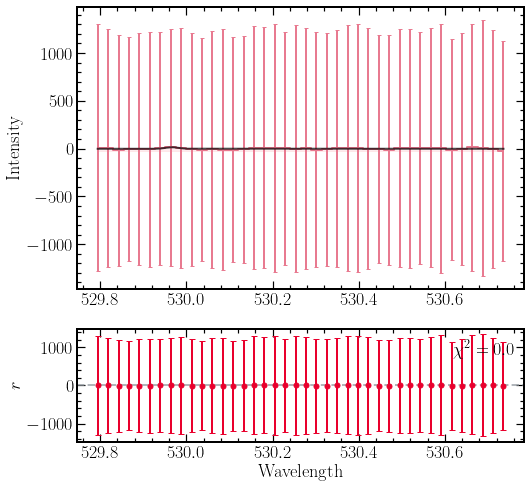

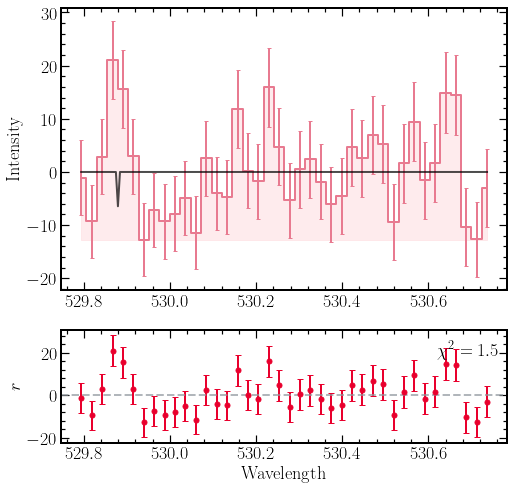

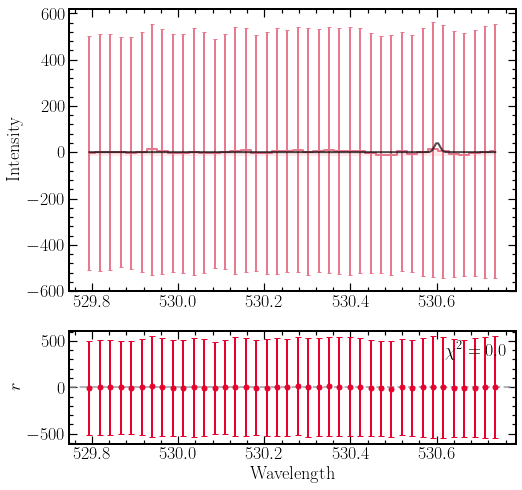

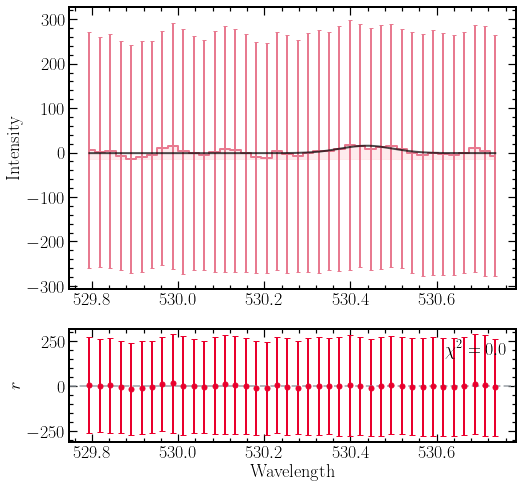

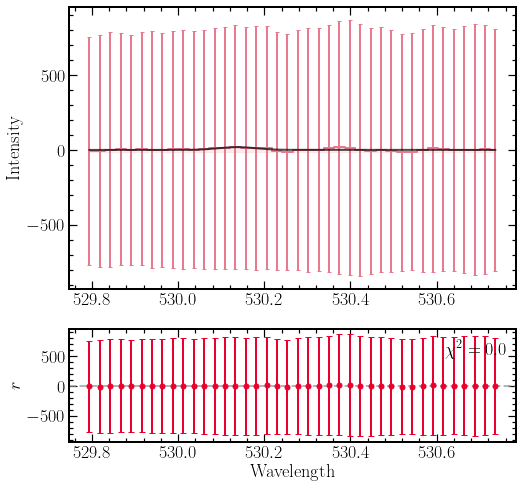

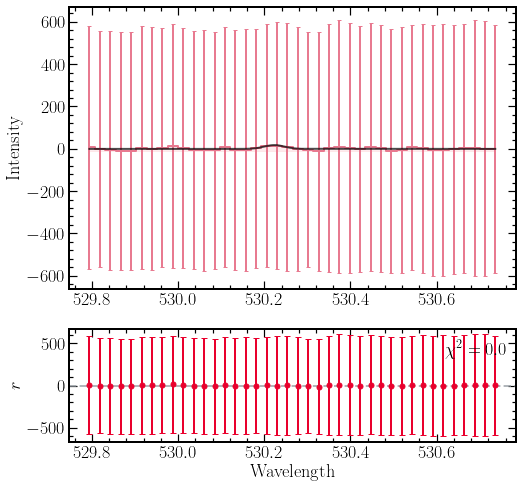

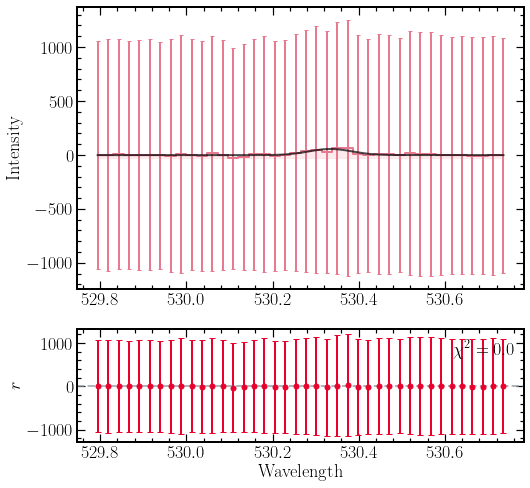

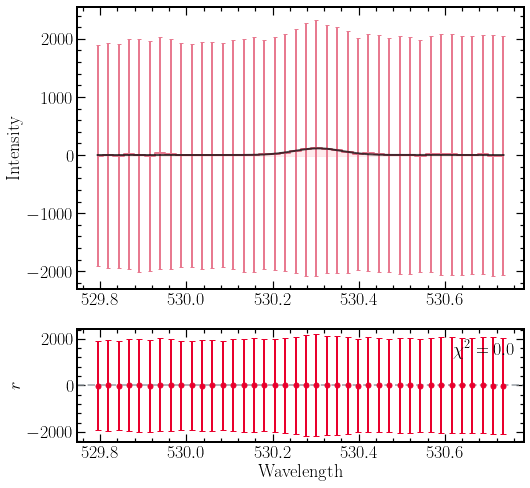

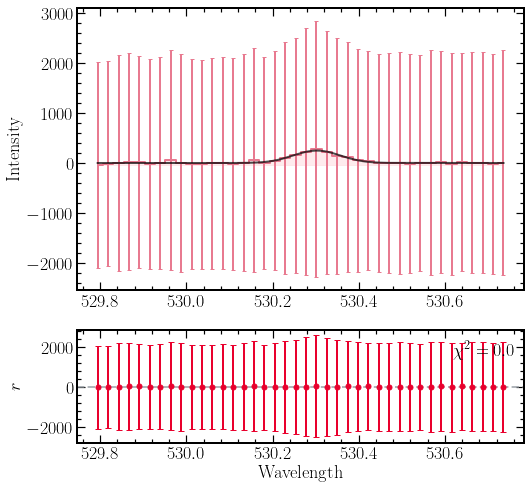

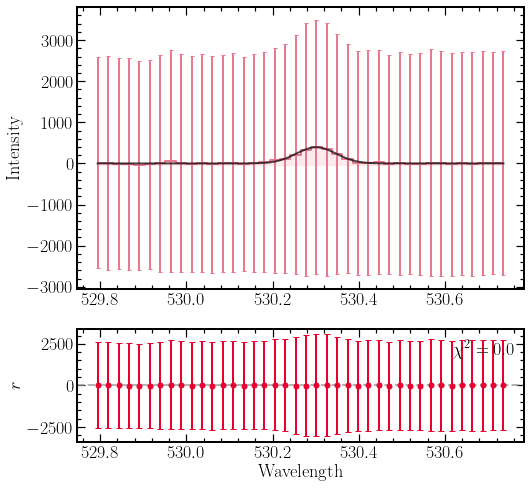

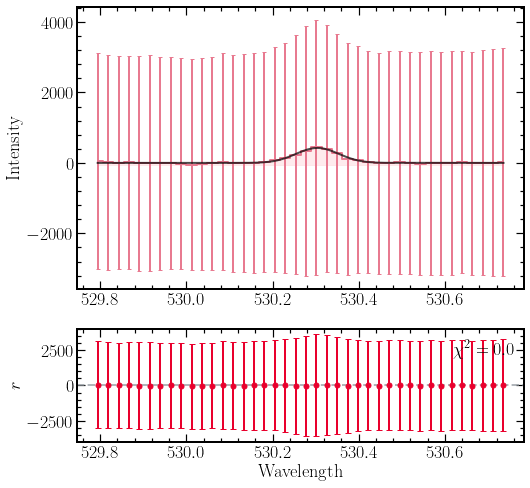

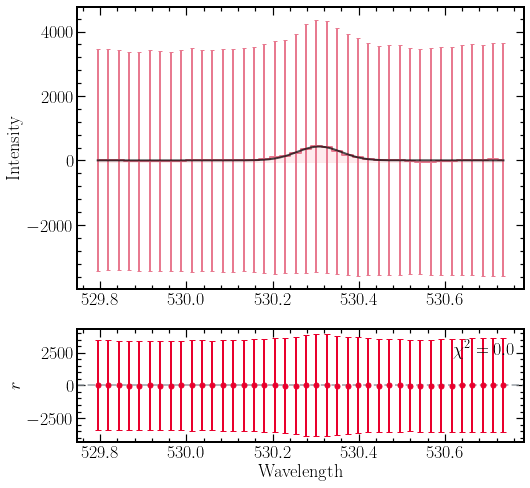

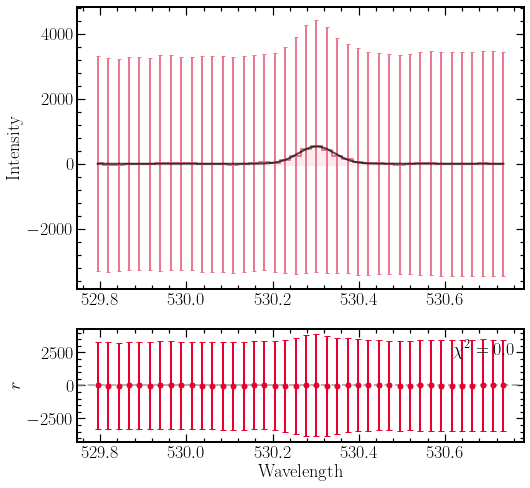

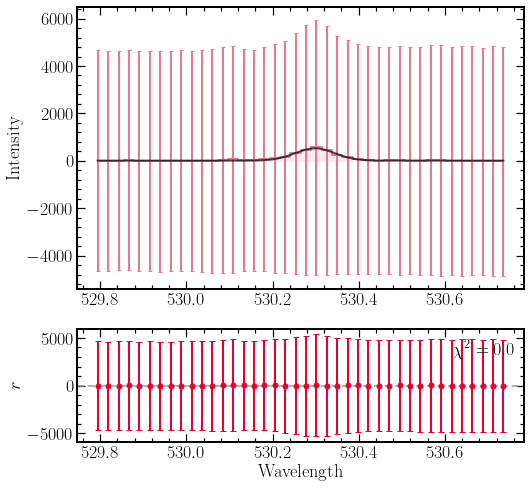

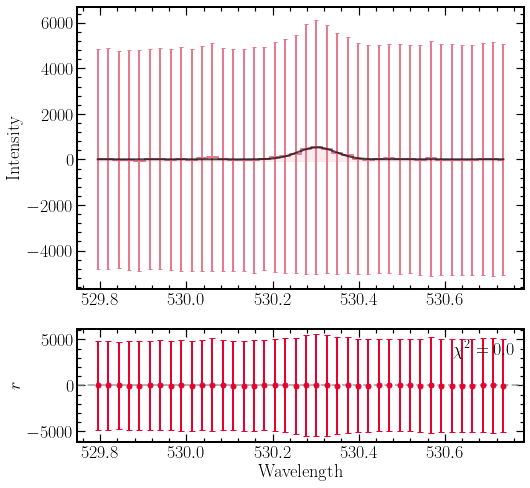

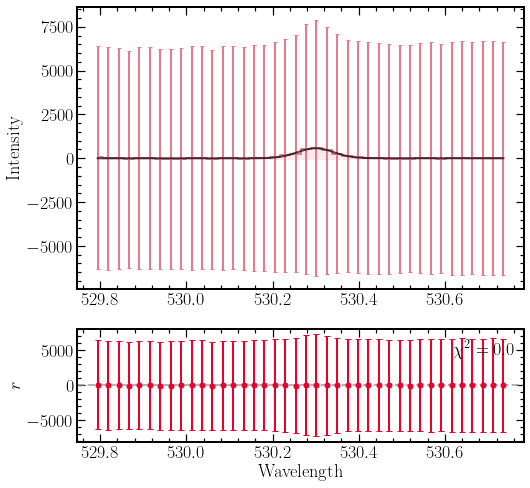

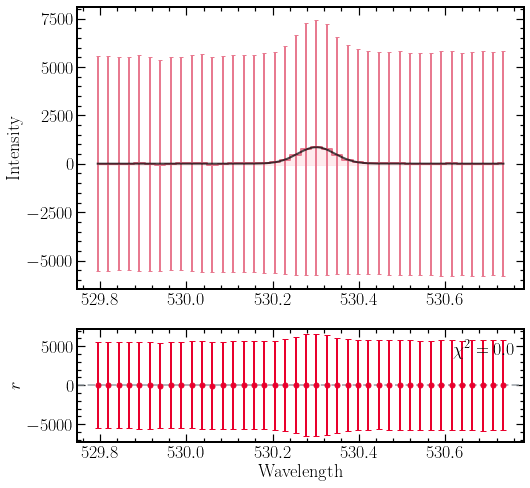

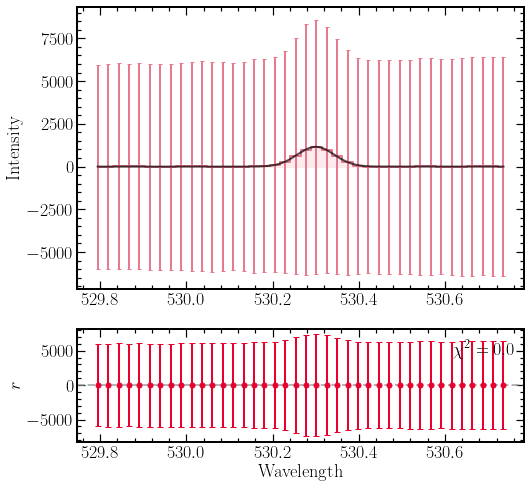

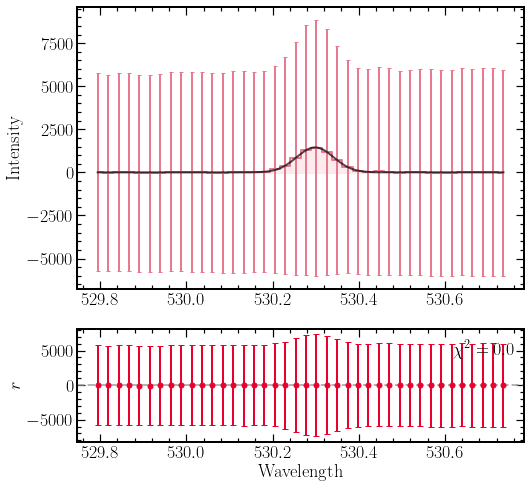

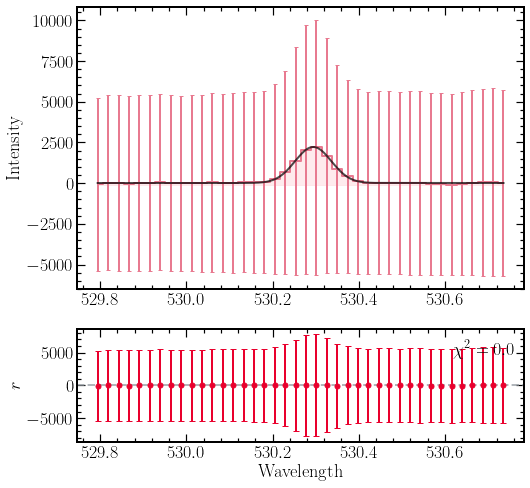

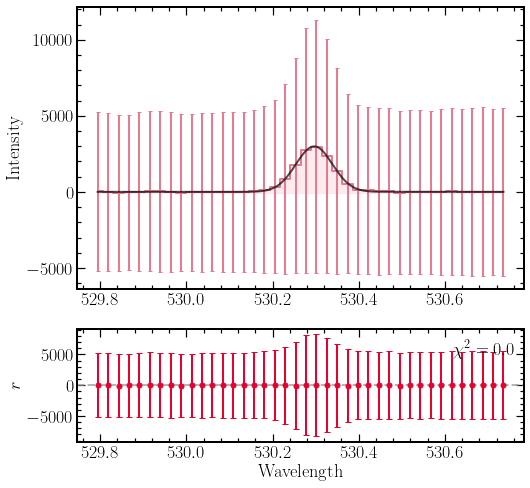

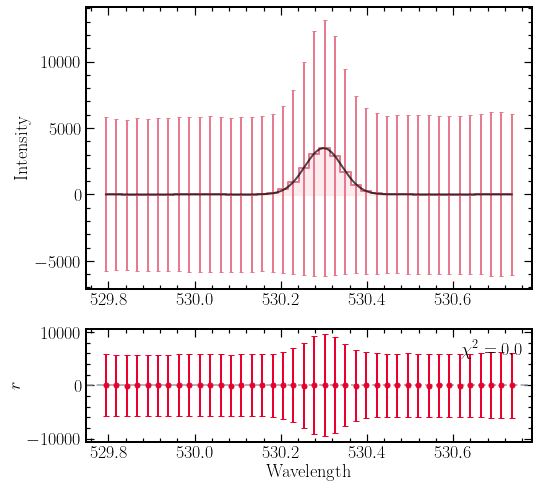

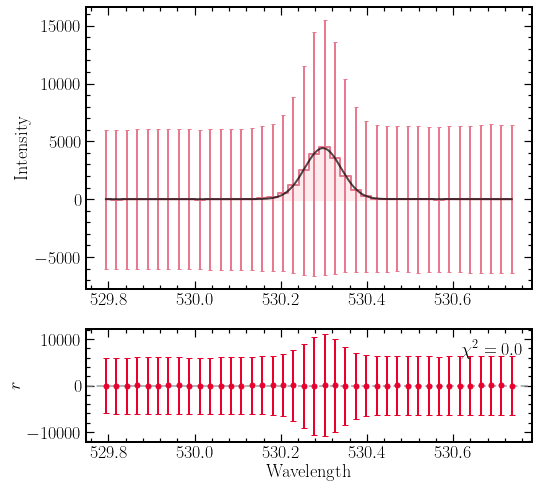

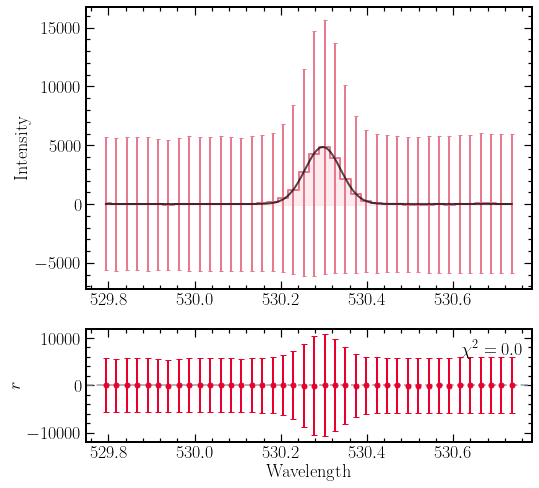

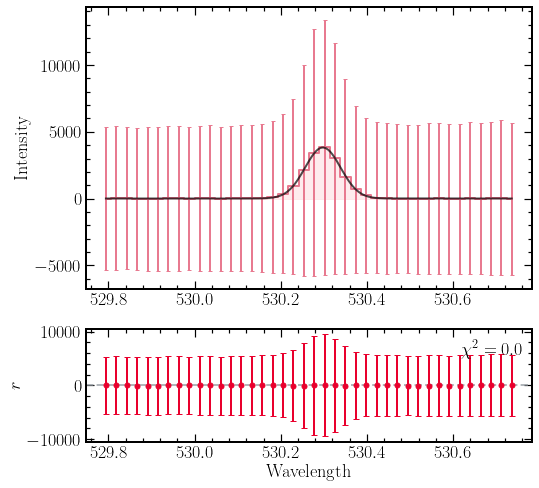

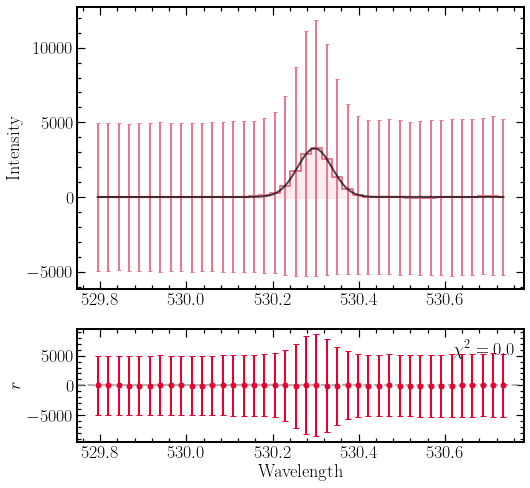

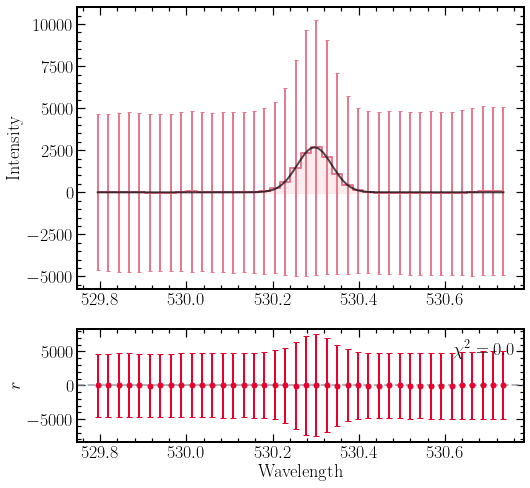

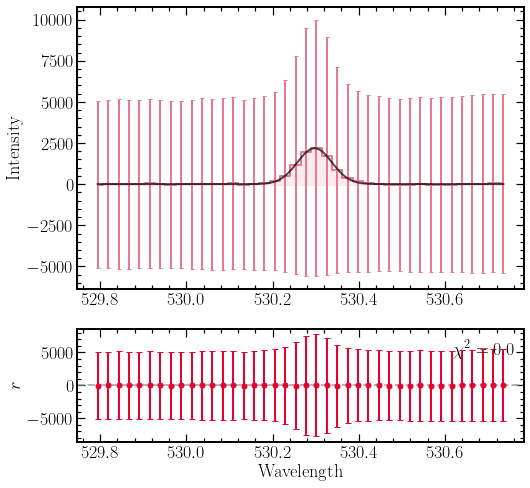

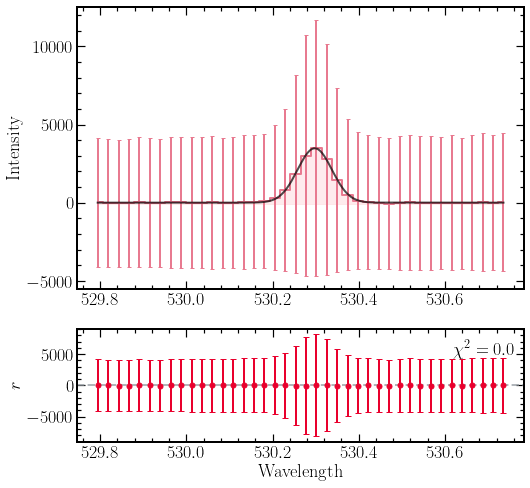

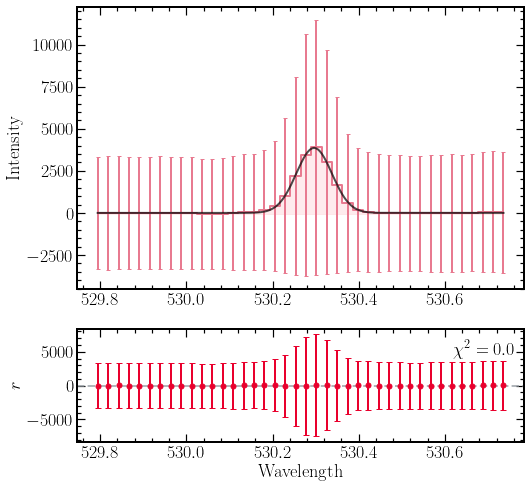

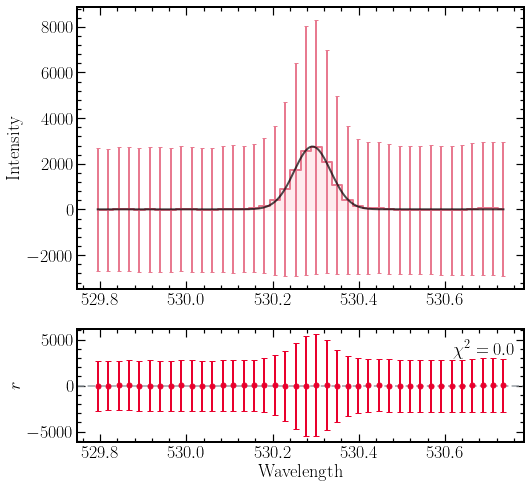

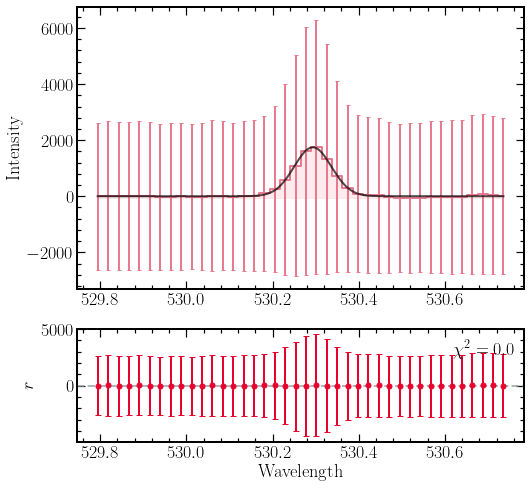

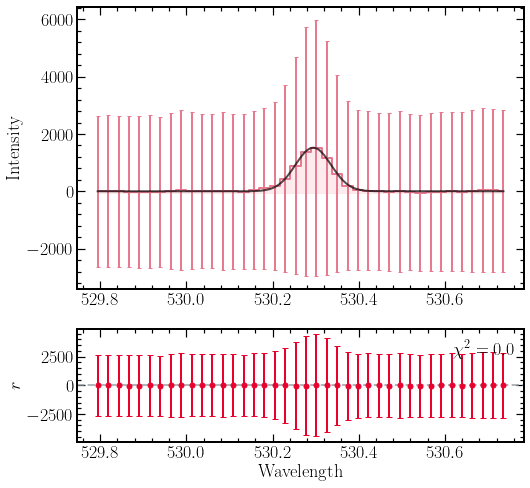

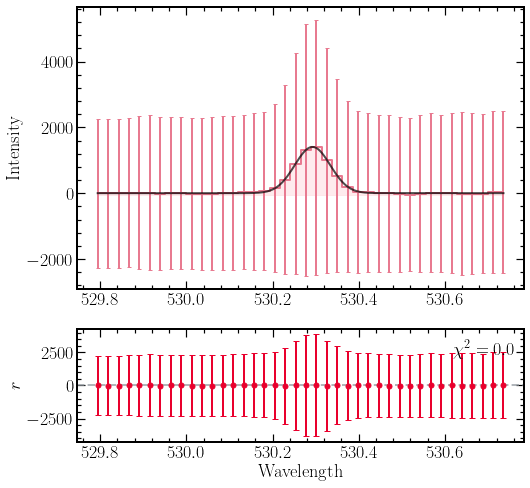

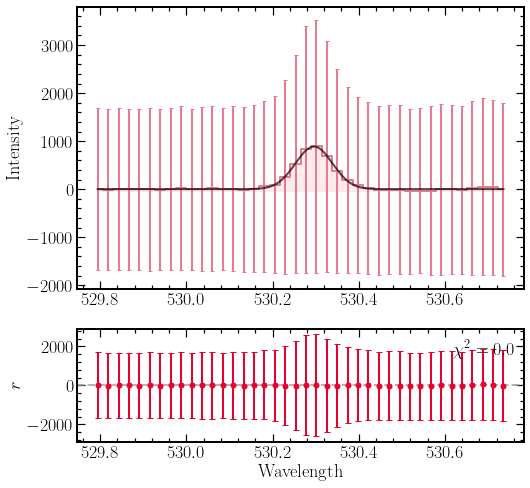

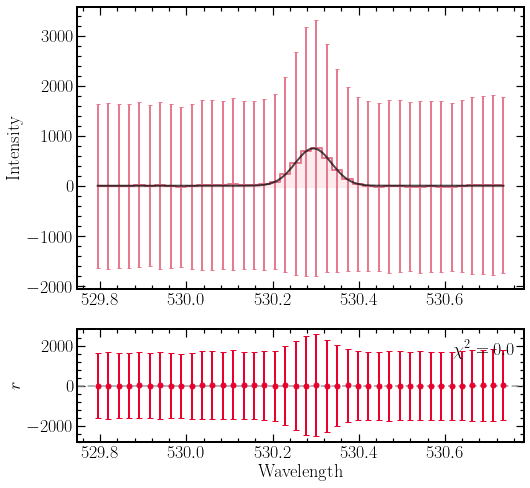

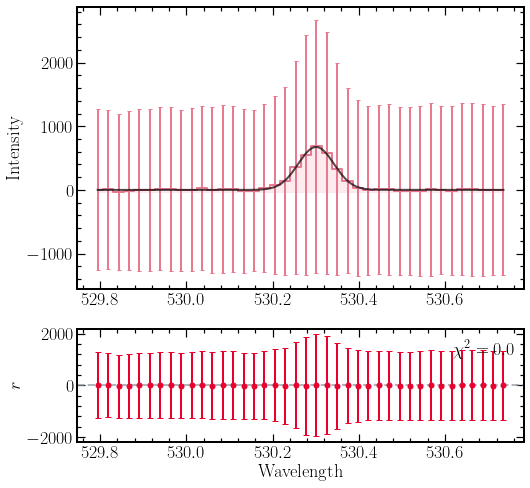

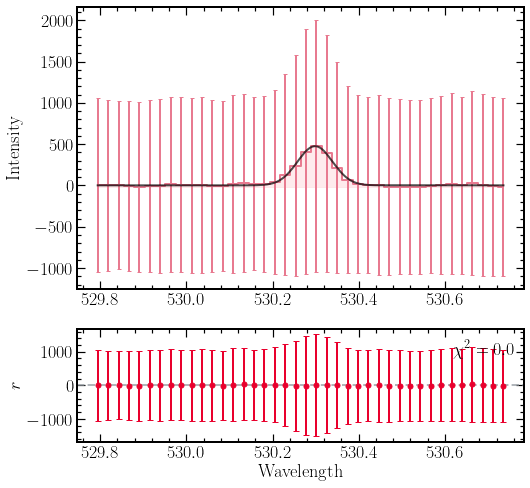

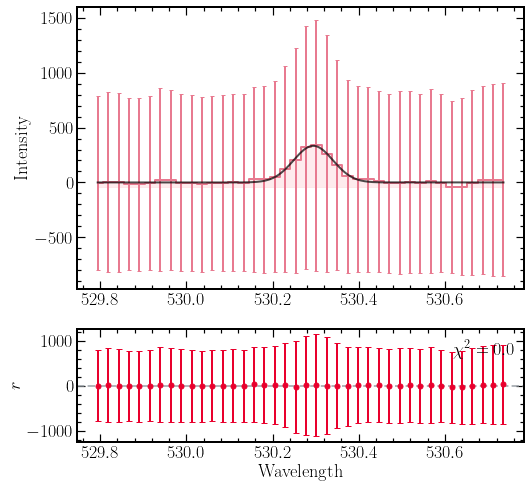

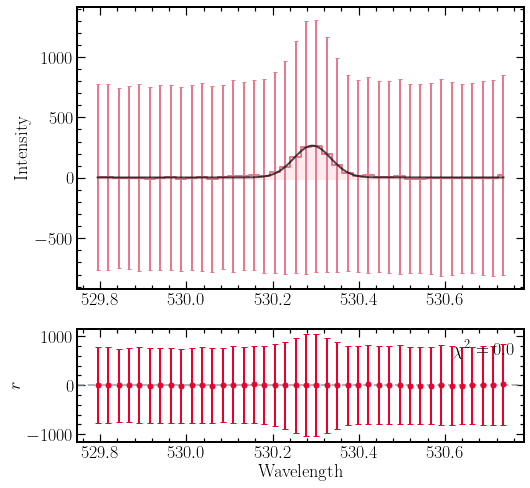

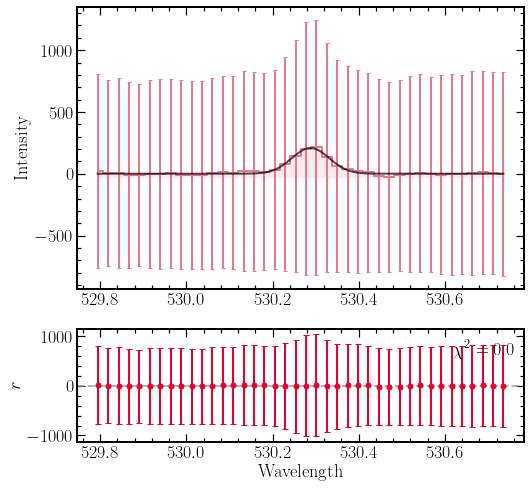

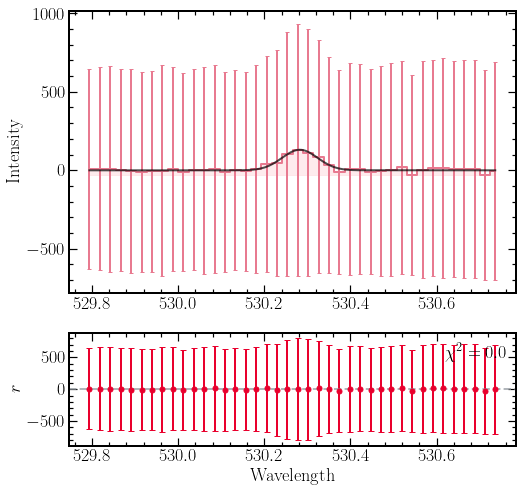

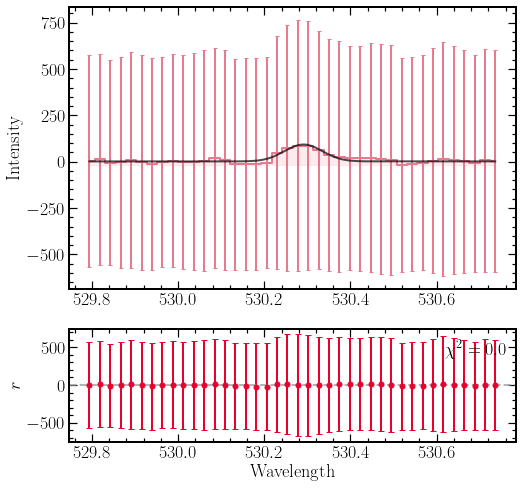

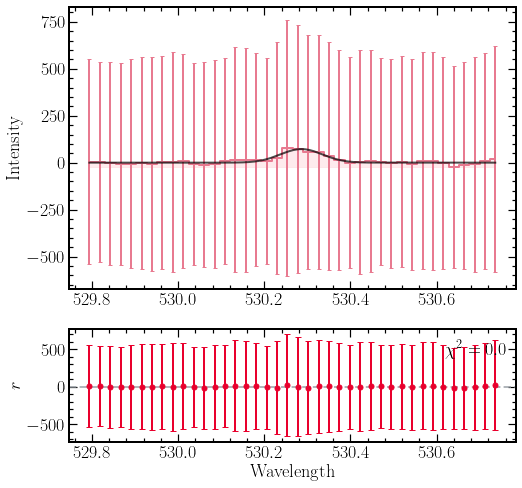

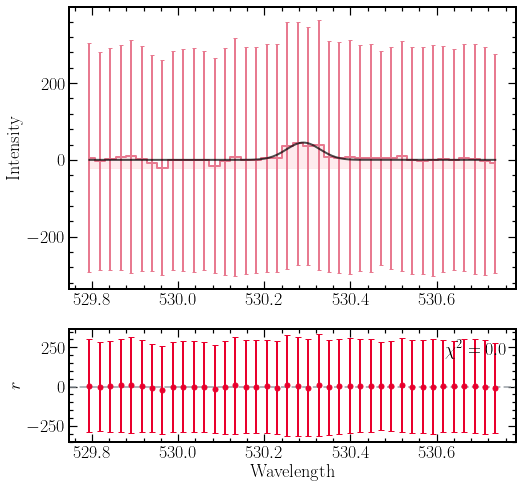

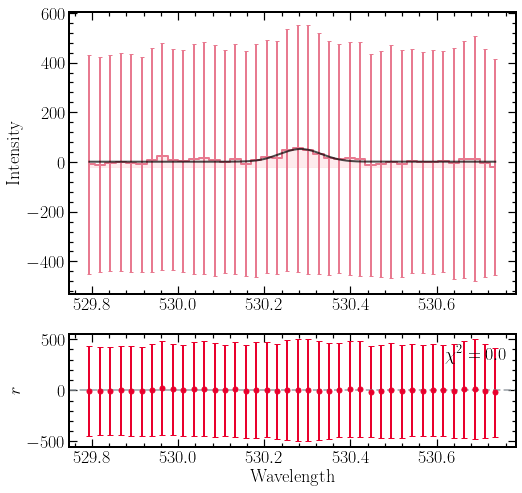

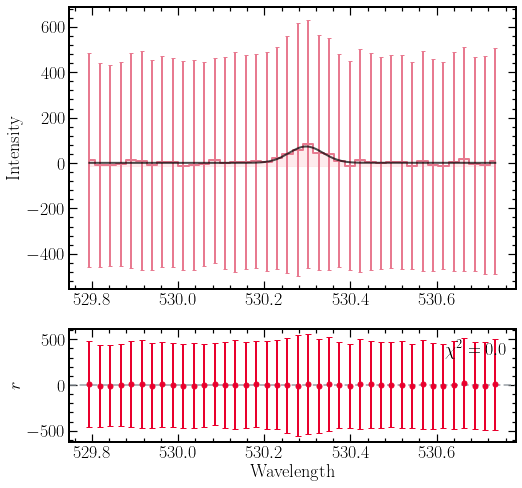

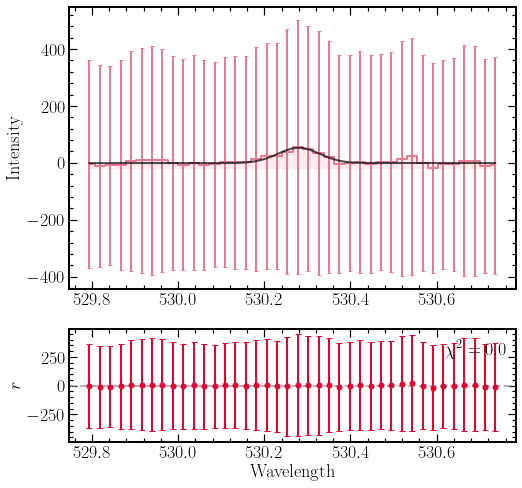

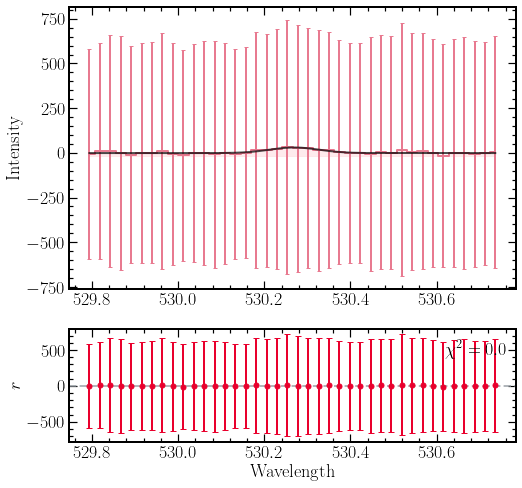

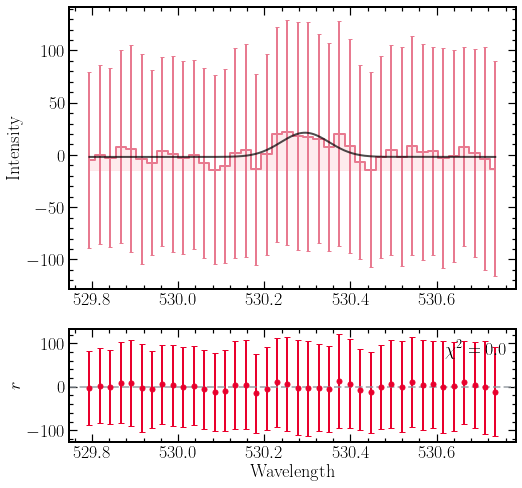

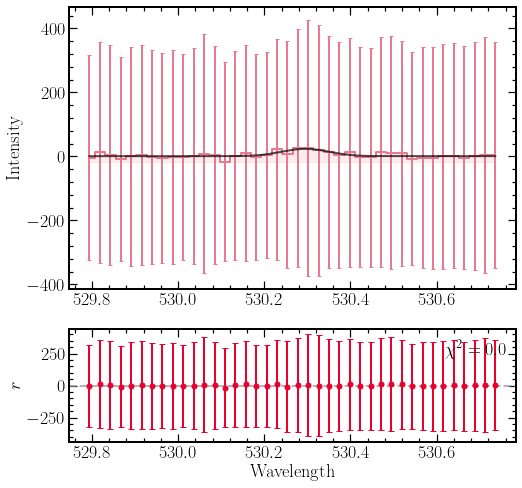

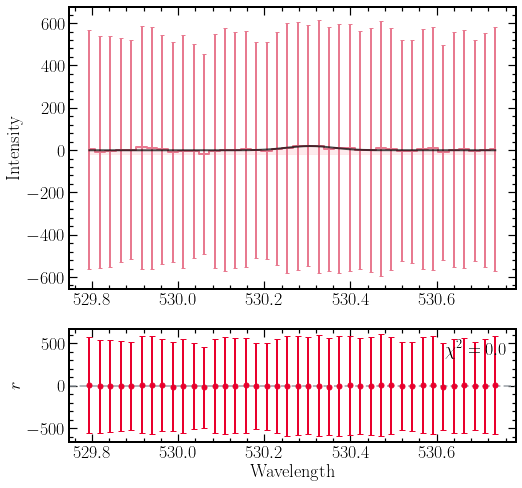

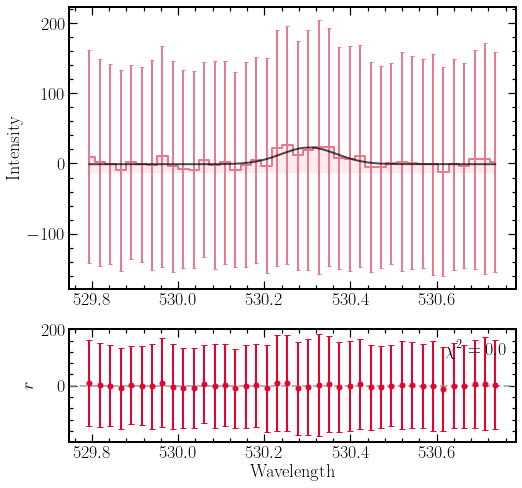

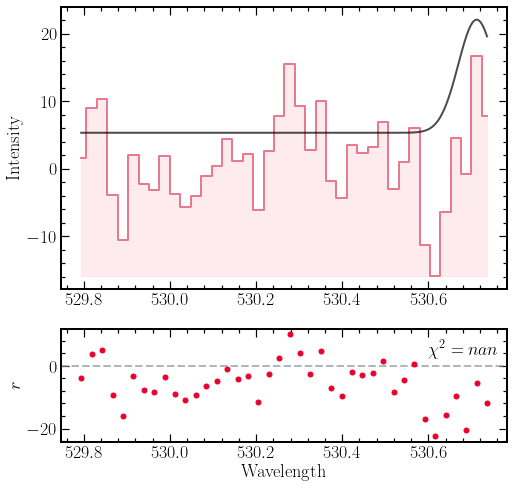

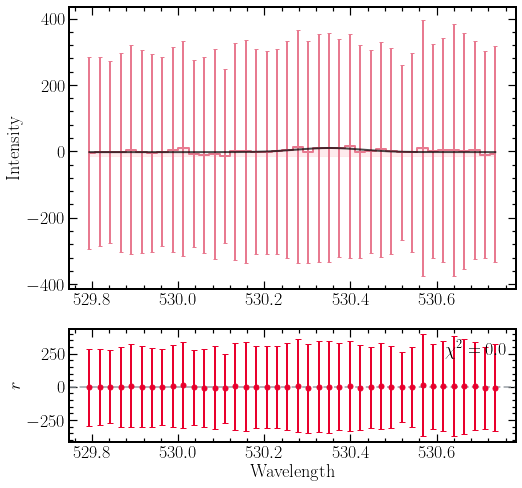

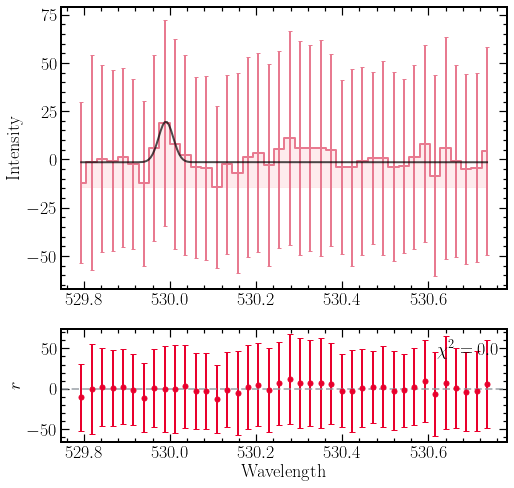

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
from scipy.interpolate import interp1d
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian

def fit_spectra(image, err, wvl, orders, flatfields, wavelength_slices, intensity_matrices,intensity_err_matrices,
                ypix_slice, cont_slice_1, cont_slice_2,nbin=5,plot_fit=False):
    
    images_sliced = [image[ypix_slice, wavelength_slice_]/flatfield_[:,np.newaxis] \
                     for (wavelength_slice_,flatfield_) in zip(wavelength_slices,flatfields)]
    errs_sliced = [err[ypix_slice, wavelength_slice_]/flatfield_[:,np.newaxis] \
                     for (wavelength_slice_,flatfield_) in zip(wavelength_slices,flatfields)]
    
    intensity_matrices = np.array(intensity_matrices)
    intensity_err_matrices = np.array(intensity_err_matrices)

    if (nbin == 1) or (nbin is None):
        pass
    else:
        for ii in range(3):
            images_sliced[ii] = np.nanmean(images_sliced[ii].reshape(-1,nbin,images_sliced[ii].shape[1]),axis=1)
            errs_sliced[ii] = np.sqrt(np.nanmean((errs_sliced[ii]**2).reshape(-1,nbin,images_sliced[ii].shape[1]),axis=1))/np.sqrt(nbin)

    images_sliced_interp = np.array(images_sliced)
    errs_sliced_interp = np.array(errs_sliced)

    wvls_sliced = [wvl[wavelength_slice_]/order_ for \
                   (wavelength_slice_ , order_)in zip(wavelength_slices, orders)]
    
    for ii in range(3):
        interp_func = interp1d(wvls_sliced[ii], images_sliced[ii],
                               kind="cubic",axis=1,fill_value="extrapolate")
        images_sliced_interp[ii,:,:] = interp_func(wvls_sliced[2])

        interp_func_err = interp1d(wvls_sliced[ii], errs_sliced[ii],
                               kind="linear",axis=1,fill_value="extrapolate")
        errs_sliced_interp[ii,:,:] = interp_func_err(wvls_sliced[2])
        
        
    image_combined = np.nanmean(images_sliced_interp/intensity_matrices[ii,:,np.newaxis]*intensity_matrices[2,:,np.newaxis],axis=0)[:,5:-5]
    err_f1 = intensity_matrices[2,:]/(3*intensity_matrices[0,:])
    err_f2 = intensity_matrices[2,:]/(3*intensity_matrices[1,:])
    err_f3 = 1./3
    err_f4 = - images_sliced_interp[0,:,:]*intensity_matrices[2,:,np.newaxis]/(3*intensity_matrices[0,:,np.newaxis]**2)
    err_f5 = - images_sliced_interp[1,:,:]*intensity_matrices[2,:,np.newaxis]/(3*intensity_matrices[1,:,np.newaxis]**2)
    err_f6 = 1./3*(images_sliced_interp[0,:,:]/intensity_matrices[0,:,np.newaxis]+ \
                    images_sliced_interp[1,:,:]/intensity_matrices[1,:,np.newaxis]) 
    
    err_combined = np.sqrt((err_f1[:,np.newaxis]*errs_sliced_interp[0,:,:])**2 + \
                            (err_f2[:,np.newaxis]*errs_sliced_interp[1,:,:])**2 + \
                            (err_f3*errs_sliced_interp[2,:,:])**2 + \
                            (err_f4*intensity_matrices[0,:,np.newaxis])**2 + \
                            (err_f5*intensity_matrices[1,:,np.newaxis])**2 + \
                            (err_f6*intensity_matrices[2,:,np.newaxis])**2)
    err_combined = err_combined[:,5:-5]

    fit_params = np.zeros((5,image_combined.shape[0]))
    fit_errs = np.zeros((5,image_combined.shape[0]))

    wvl_sliced = wvls_sliced[2][5:-5]

    for ii in range(image_combined.shape[0]):
        fit_params[:,ii], fit_errs[:,ii] = fit_spectra_single(wvl_sliced[np.r_[cont_slice_1, cont_slice_2]], 
                                image_combined[ii, np.r_[cont_slice_1, cont_slice_2]],wvl_sliced, image_combined[ii,:],
                                None,plot_fit=plot_fit)

    return fit_params, fit_errs


def fit_spectra_single(cont_wvl, cont_int, wvl, int, err, plot_fit=False):
    cont_fit_param = np.polyfit(cont_wvl, cont_int, deg = 1)
    cont_fit_poly = np.poly1d(cont_fit_param)

    int_res = int - cont_fit_poly(wvl)

    fit_model = SpectrumFitSingle(data=int_res,err=err, wvl=wvl,line_number=1,
                        line_wvl_init=wvl[np.argmax(int_res)],int_max_init=int_res.max(),fwhm_init=0.1)

    try:
        fit_model.run_lse(absolute_sigma=False)
    except:
        pass
    if plot_fit:
        fit_model.plot(plot_params=False)
        print(fit_model.fwhm_fit)

    return np.array([fit_model.line_wvl_fit[0], fit_model.int_total_fit[0], fit_model.fwhm_fit[0],
                      fit_model.int_cont_fit, cont_fit_poly(fit_model.line_wvl_fit[0])]), \
            np.array([fit_model.line_wvl_err[0], fit_model.int_total_err[0], fit_model.fwhm_err[0],
                    fit_model.int_cont_err, 0])


green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_63rd.h5", 'r') as hf:
    flatfield_1d_FeXIV_63rd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_62nd.h5", 'r') as hf:
    flatfield_1d_FeXIV_62nd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_green_1d_FeXIV_61st.h5", 'r') as hf:
    flatfield_1d_FeXIV_61st = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_52nd.h5", 'r') as hf:
    flatfield_1d_FeX_52nd = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_51st.h5", 'r') as hf:
    flatfield_1d_FeX_51st = hf['flatfield_1d'][:]

with h5py.File("../../sav/Eclipse/FlatField/skyflat_red_1d_FeX_53rd.h5", 'r') as hf:
    flatfield_1d_FeX_53rd = hf['flatfield_1d'][:]


with h5py.File("../../sav/Eclipse/FitResults/FeXIV_61.h5","r") as hf:
    FeXIV_61_intensity = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_61_intensity_err = np.flip(hf["green_fit_matrix_ext_err"][1,:])
    FeXIV_61_intensity_bin = np.flip(hf["green_fit_matrix_bin_ext"][1,:])
    FeXIV_61_intensity_bin_err = np.flip(hf["green_fit_matrix_bin_ext_err"][1,:])

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_62.h5","r") as hf:
    FeXIV_62_intensity = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_62_intensity_err = np.flip(hf["green_fit_matrix_ext_err"][1,:])
    FeXIV_62_intensity_bin = np.flip(hf["green_fit_matrix_bin_ext"][1,:])
    FeXIV_62_intensity_bin_err = np.flip(hf["green_fit_matrix_bin_ext_err"][1,:])

with h5py.File("../../sav/Eclipse/FitResults/FeXIV_63.h5","r") as hf:
    FeXIV_63_intensity = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_63_intensity_err = np.flip(hf["green_fit_matrix_ext"][1,:])
    FeXIV_63_intensity_bin = np.flip(hf["green_fit_matrix_bin_ext"][1,:])
    FeXIV_63_intensity_bin_err = np.flip(hf["green_fit_matrix_bin_ext_err"][1,:])

FeXIV_order = [61,62,63]
FeXIV_flatfields = [flatfield_1d_FeXIV_61st,flatfield_1d_FeXIV_62nd,flatfield_1d_FeXIV_63rd]
FeXIV_xslices = [slice(1010,1060),slice(685,735),slice(345,395)]


starttime_green_ext = datetime(2017,8,21,17,45,36)
# green_fit_matrix_ext = np.full((5,350,188),np.nan,dtype=np.float64)
# green_fit_matrix_ext_err = np.full((5,350,188),np.nan,dtype=np.float64)
# green_fit_filename_index = np.full(188,np.nan,dtype=np.int32)
# for ii, row_ in totality_green_df_ext.iterrows(): 
#     date_obs = row_["date-obs"]
#     exptime = np.float64(row_["exptime"])
#     readout_noise = np.float64(row_["ronoise"])

#     time_difference = date_obs - starttime_green_ext
#     startindex = int(time_difference.total_seconds()*2)
#     endindex = startindex + int(exptime*2)

#     green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
#     green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data
#     green_frame_noise_ = np.sqrt(green_frame_.data*exptime + readout_noise**2)/exptime

#     FeXIV_fit_, FeXIV_fit_err_ = fit_spectra(green_frame_.data/exptime,
#     green_frame_noise_, green_frame_wavelength_/10., FeXIV_order, FeXIV_flatfields, FeXIV_xslices,
#     [FeXIV_61_intensity[:,startindex],FeXIV_62_intensity[:,startindex],FeXIV_63_intensity[:,startindex]],
#     [FeXIV_61_intensity_err[:,startindex],FeXIV_62_intensity_err[:,startindex],FeXIV_63_intensity_err[:,startindex]],
#     slice(0,None), slice(0,10),slice(30,40), nbin=None)

#     green_fit_matrix_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
#     green_fit_matrix_ext_err[:,:,startindex:endindex] = FeXIV_fit_err_[:,:,np.newaxis]
#     green_fit_filename_index[startindex:endindex] = ii

# green_fit_matrix_ext = np.flip(green_fit_matrix_ext,axis=(1,2))
# green_fit_matrix_ext_err = np.flip(green_fit_matrix_ext_err,axis=(1,2))
# green_fit_filename_index = np.flip(green_fit_filename_index)

# green_fit_matrix_bin_ext = np.full((5,70,188),np.nan,dtype=np.float64)
# green_fit_matrix_bin_ext_err = np.full((5,70,188),np.nan,dtype=np.float64)
for ii, row_ in totality_green_df_ext.iterrows(): 
    date_obs = row_["date-obs"]
    exptime = np.float64(row_["exptime"])
    readout_noise = np.float64(row_["ronoise"])

    time_difference = date_obs - starttime_green_ext
    startindex = int(time_difference.total_seconds()*2)
    endindex = startindex + int(exptime*2)

    green_frame_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=0,unit="adu")
    green_frame_wavelength_ = CCDData.read(os.path.join(green_path,row_["file"]),hdu=2,unit="adu").data
    green_frame_noise_ = np.sqrt(green_frame_.data*exptime + readout_noise**2)/exptime


    if row_["file"] == "TotalitySequenceGreen_22717(2)_l1.fit":
        plot_fit = True
    else:
        plot_fit = False
        
    FeXIV_fit_, FeXIV_fit_err_ = fit_spectra(green_frame_.data/exptime,
    green_frame_noise_,green_frame_wavelength_/10., FeXIV_order, FeXIV_flatfields, FeXIV_xslices,
    [FeXIV_61_intensity_bin[:,startindex],FeXIV_62_intensity_bin[:,startindex],FeXIV_63_intensity_bin[:,startindex]],
    [FeXIV_61_intensity_bin_err[:,startindex],FeXIV_62_intensity_bin_err[:,startindex],FeXIV_63_intensity_bin_err[:,startindex]],
    slice(0,None), slice(0,10),slice(30,40), nbin=5, plot_fit=plot_fit)

    green_fit_matrix_bin_ext[:,:,startindex:endindex] = FeXIV_fit_[:,:,np.newaxis]
    green_fit_matrix_bin_ext_err[:,:,startindex:endindex] = FeXIV_fit_err_[:,:,np.newaxis]
green_fit_matrix_bin_ext = np.flip(green_fit_matrix_bin_ext,axis=(1,2))
green_fit_matrix_bin_ext_err = np.flip(green_fit_matrix_bin_ext_err,axis=(1,2))

# with h5py.File("../../sav/Eclipse/FitResults/FeXIV_add3orders.h5", 'w') as hf:
#     df_green_fit_matrix_ext = hf.create_dataset("green_fit_matrix_ext",  data=green_fit_matrix_ext)
#     df_green_fit_matrix_ext_err = hf.create_dataset("green_fit_matrix_ext_err",  data=green_fit_matrix_ext_err)
#     df_green_fit_matrix_bin_ext = hf.create_dataset("green_fit_matrix_bin_ext",  data=green_fit_matrix_bin_ext)
#     df_green_fit_matrix_bin_ext_err = hf.create_dataset("green_fit_matrix_bin_ext_err",  data=green_fit_matrix_bin_ext_err)
#     df_green_fit_filename_index = hf.create_dataset("green_fit_filename_index",  data=green_fit_filename_index)
#     df_green_fit_matrix_ext.attrs["description"] = "wvl;int;fwhm;cont_fit;cont_bg_poly"




